# Data Visualization with the `plotnine` Package

In [7]:
# Loading Libraries
import polars as pl
import polars.selectors as cs
from plotnine import *
from mizani.labels import label_number

In [3]:
# Importing south sudan census dataset
url = 'https://raw.githubusercontent.com/tongakuot/python_tutorials/main/00_data/ss_2008_census_data_raw.csv'

# Write a function for cleaning and transforming South Sudan census data
def tweak_census(df, grouping_cols, condition):
    """
    Cleans and transforms South Sudan census data.

    This function processes a DataFrame containing South Sudan census data by:
    - Selecting relevant columns
    - Renaming and recategorizing age groups
    - Filtering rows based on a given condition
    - Handling null values
    - Renaming columns for clarity
    - Adding a new column to categorize regions
    - Grouping data by specified columns
    - Aggregating population counts
    - Sorting the results in descending order of total population

    Parameters:
    df (pl.DataFrame): The input DataFrame containing South Sudan census data.
    grouping_cols (list): A list of column names to group by.
    condition (pl.Expr): A condition to filter the DataFrame.

    Returns:
    pl.DataFrame: A transformed DataFrame with aggregated population counts, grouped by specified columns, and sorted by total population.
    """
    age_mappings = {'0 to 4':'0-14', 
                '5 to 9':'0-14', 
                '10 to 14':'0-14', 
                '15 to 19':'15-24', 
                '20 to 24':'15-24', 
                '25 to 29':'25-34', 
                '30 to 34':'25-34', 
                '35 to 39':'35-44', 
                '40 to 44':'35-44',
                '45 to 49':'45-54', 
                '50 to 54':'45-54',
                '55 to 59':'55-64',
                '60 to 64':'55-64',
                '65+':'65 and above'
               }
    # new_cats = [, '0-14', '0-14',
    #             '15-24', '15-24',
    #             '25-34', '25-34',
    #             '35-44', '35-44',
    #             '45-54', '45-54',
    #             '55-64', '55-64',
    #             '65 and above'
    #            ]
    return (
        df
        .select(cs.ends_with('Name'), '2008')
        .with_columns(
            gender=pl.col('Variable Name').str.replace_many(['Population, ', ' (Number)'], ''),
            category=pl.col('Age Name').replace(age_mappings)
        )
        .select(pl.col('*').exclude(['Variable Name', 'Age Name']))
        .filter(condition)
        .drop_nulls()
        .rename({'Region Name': 'state', '2008': 'population'})
        .with_columns(former_region=pl.when(pl.col('state').is_in(['Upper Nile', 'Unity', 'Jonglei']))
                                    .then(pl.lit('Greater Upper Nile'))
                                    .when(pl.col('state').str.ends_with('Equatoria'))
                                    .then(pl.lit('Greater Equatoria'))
                                    .when(pl.col('state').str.contains('Ghazal'))
                                    .then(pl.lit('Greater Bahr el Ghazal'))
                                    .otherwise(pl.lit('Greater Bahr el Ghazal'))
        )
        .group_by(grouping_cols)
        .agg(total=pl.col('population').sum())
        .sort('total', descending=True)
    )   

In [4]:
census_raw = pl.read_csv(url, null_values='NA')


In [5]:
census = (
    tweak_census(
    census_raw, 
    grouping_cols=['former_region', 'state', 'gender', 'category'], 
    condition=~((pl.col('gender') == 'Total') | (pl.col('category') == 'Total')) 
    )
)

# inspect the first 5 rows
print(census)

shape: (140, 5)
┌────────────────────────┬────────────────────────┬────────┬──────────────┬────────┐
│ former_region          ┆ state                  ┆ gender ┆ category     ┆ total  │
│ ---                    ┆ ---                    ┆ ---    ┆ ---          ┆ ---    │
│ str                    ┆ str                    ┆ str    ┆ str          ┆ i64    │
╞════════════════════════╪════════════════════════╪════════╪══════════════╪════════╡
│ Greater Upper Nile     ┆ Jonglei                ┆ Male   ┆ 0-14         ┆ 338443 │
│ Greater Upper Nile     ┆ Jonglei                ┆ Female ┆ 0-14         ┆ 263646 │
│ Greater Equatoria      ┆ Central Equatoria      ┆ Male   ┆ 0-14         ┆ 242247 │
│ Greater Upper Nile     ┆ Upper Nile             ┆ Male   ┆ 0-14         ┆ 237461 │
│ Greater Bahr el Ghazal ┆ Warrap                 ┆ Male   ┆ 0-14         ┆ 230854 │
│ …                      ┆ …                      ┆ …      ┆ …            ┆ …      │
│ Greater Bahr el Ghazal ┆ Lakes                 

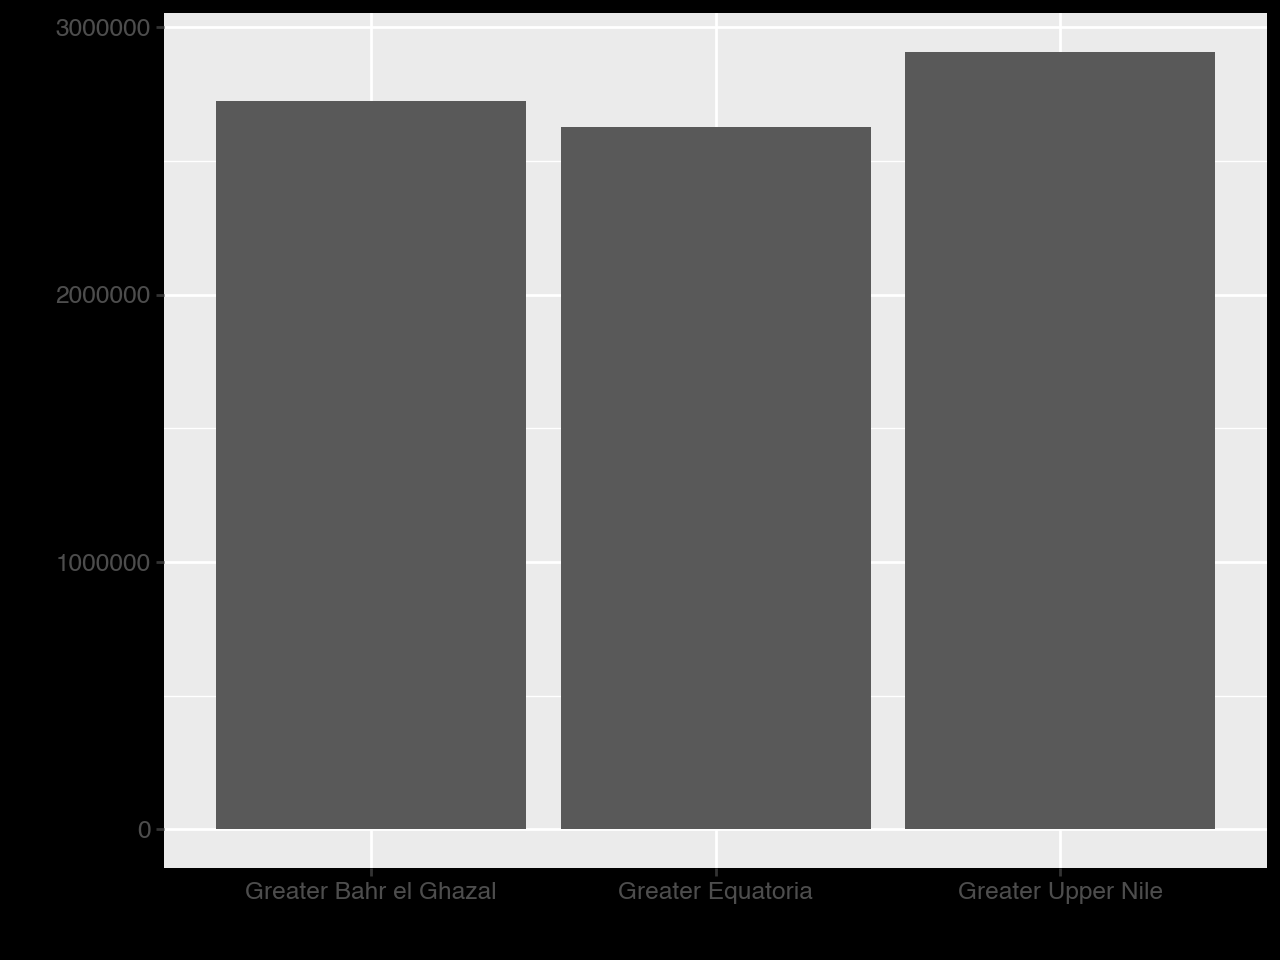

In [17]:
# Visualize the 2008 South Sudan Census by Former Region
(
    ggplot(census, aes('former_region', 'total'))
    + geom_bar(stat='identity') 
)

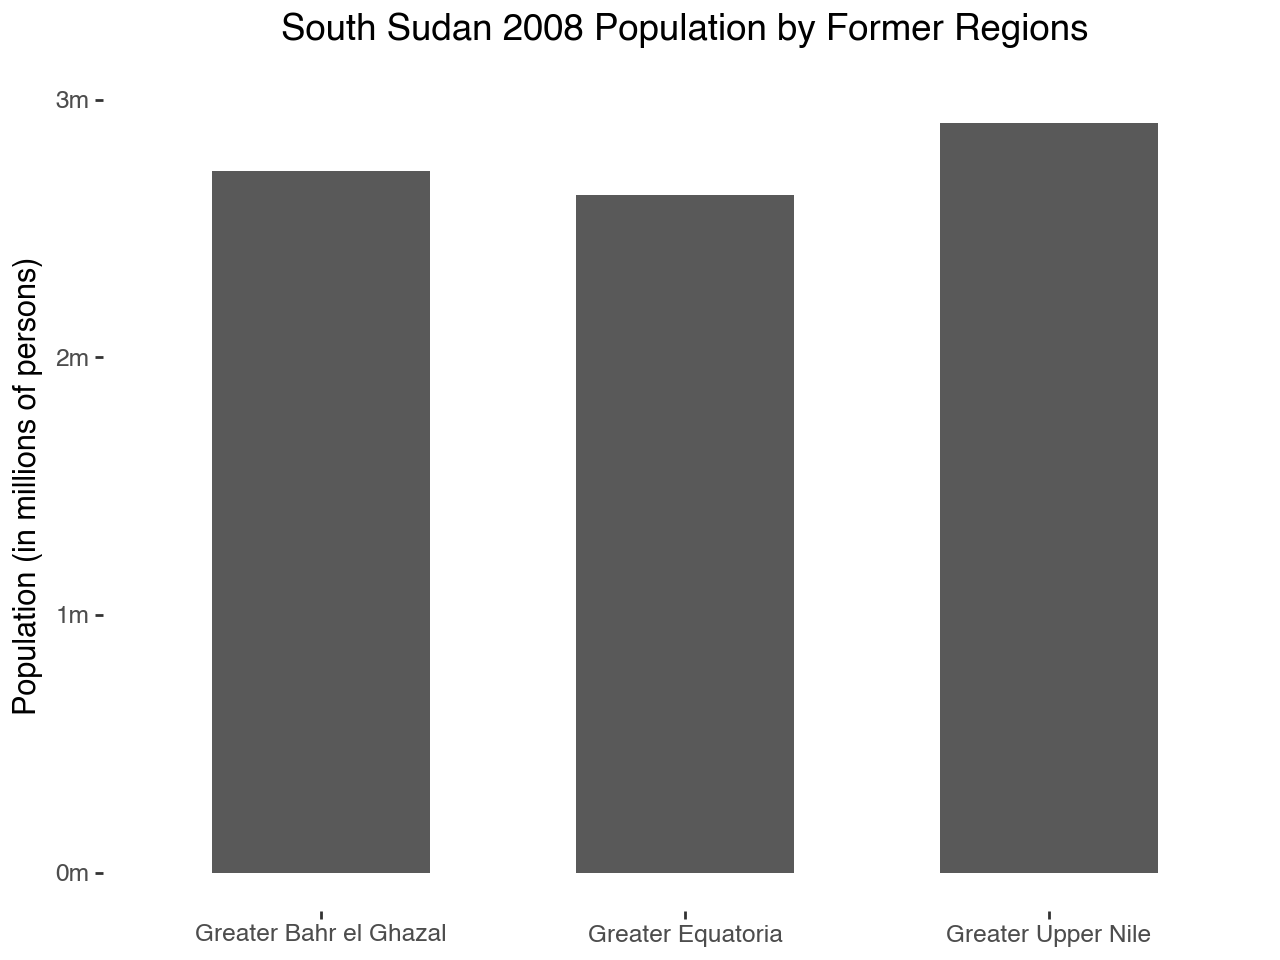

In [19]:
# Beautify it
(
    ggplot(census, aes('former_region', 'total'))
    + geom_bar(stat='identity', width=0.6) 
    + scale_y_continuous(
        limits=(0, 3_000_000), 
        labels=label_number(scale=1e-6, suffix='m')
    )
    + theme_tufte() 
    + labs(
        x='',
        y='Population (in millions of persons)',
        title='South Sudan 2008 Population by Former Regions'
    )
)

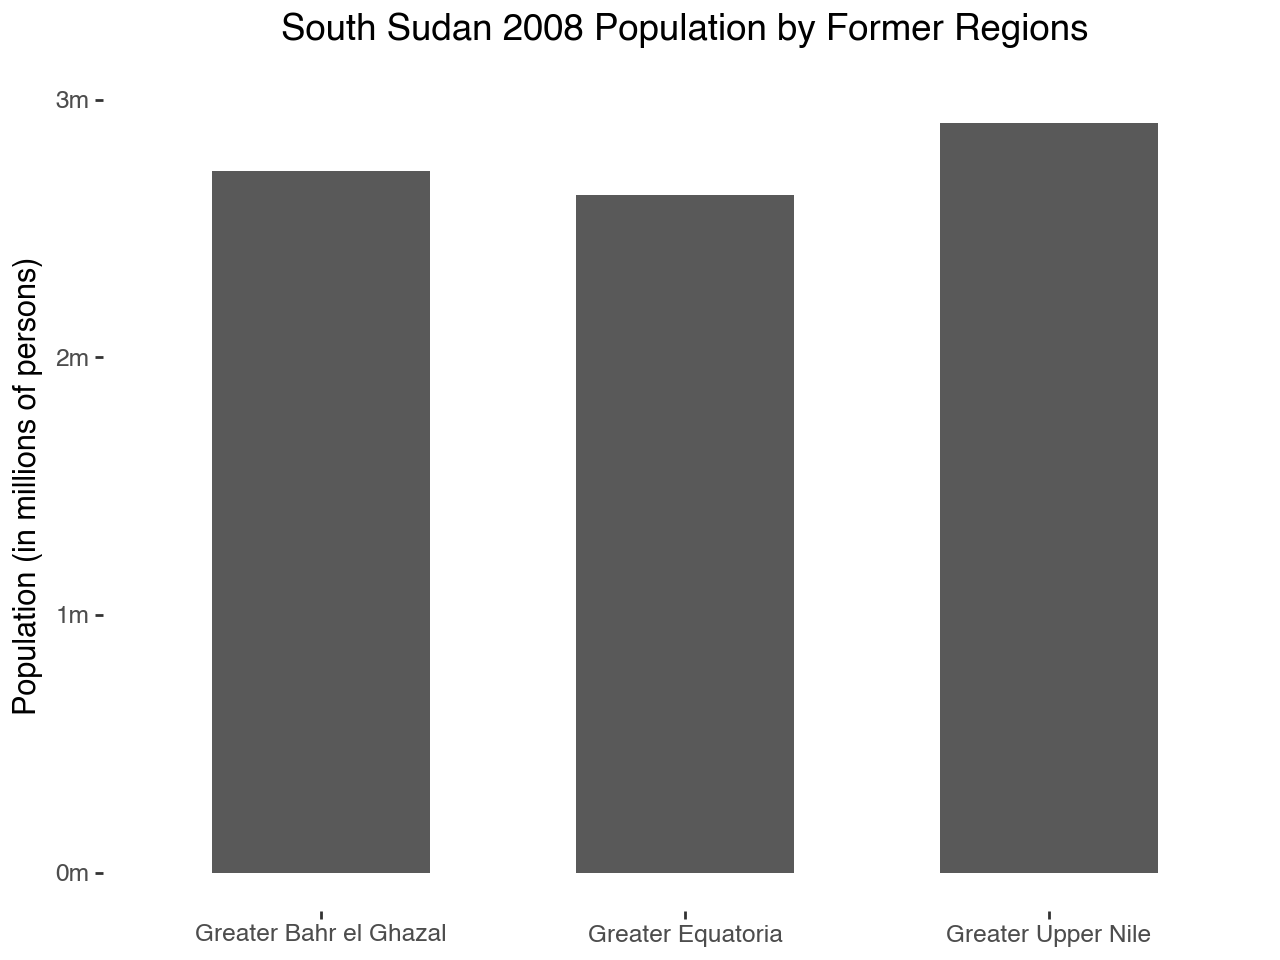

In [28]:
# Improve it further
(
    ggplot(census, aes('former_region', 'total'))
    + geom_bar(stat='identity', width=0.6) 
    + scale_y_continuous(
        limits=(0, 3_000_000), 
        labels=label_number(scale=1e-6, suffix='m')
    )
    + theme_tufte() 
    + labs(
        x='',
        y='Population (in millions of persons)',
        title='South Sudan 2008 Population by Former Regions'
    )
)

In [27]:
former_region = (
    census
    .group_by('former_region')
    .agg(total=pl.col('total').sum())
    .sort('total', descending=True)
)

# inspect the summary
print(former_region)

shape: (3, 2)
┌────────────────────────┬─────────┐
│ former_region          ┆ total   │
│ ---                    ┆ ---     │
│ str                    ┆ i64     │
╞════════════════════════╪═════════╡
│ Greater Upper Nile     ┆ 2908756 │
│ Greater Bahr el Ghazal ┆ 2722987 │
│ Greater Equatoria      ┆ 2628747 │
└────────────────────────┴─────────┘


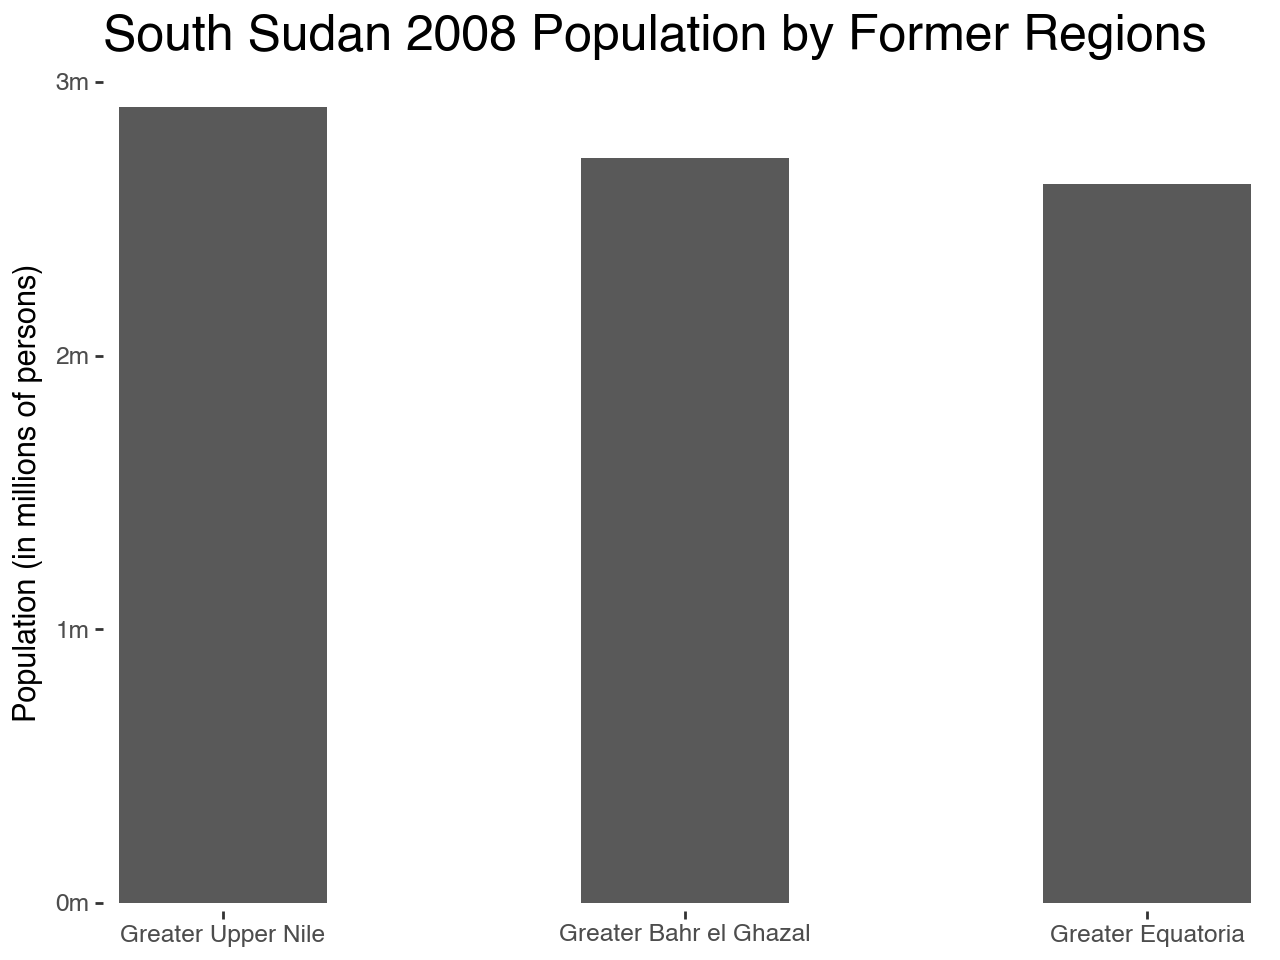

In [121]:
# Visualize with geom_col
regions = ['Greater Upper Nile', 'Greater Bahr el Ghazal', 'Greater Equatoria']
(
    ggplot(census, aes('former_region', 'total'))
    + geom_col(stat='identity', width=0.45) 
    + scale_y_continuous(
        limits=(0, 3_000_000), 
        expand=(0.01, 0.01),
        labels=label_number(scale=1e-6, suffix='m')
    )
    + scale_x_discrete(limits=regions, expand=(0.01, 0.01))
    + theme_tufte() 
    + labs(
        x='',
        y='Population (in millions of persons)',
        title='South Sudan 2008 Population by Former Regions'
    )
    + theme(
        plot_title=element_text(size=18, ha=0, margin={'t': 15, 'b': 5}),
    )
)